In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import joblib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#load and download dataset
def load_minist_dataset():
    # define a transform to normalize the data
    transform = transforms.Compose([transforms.ToTensor()])
    # download and load the training data
    trainset = datasets.MNIST('./datasets', download=True, train=True, transform=transform)
    # download and load the test data
    testset = datasets.MNIST('./datasets', download=True, train=False, transform=transform)
    return trainset,testset


X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


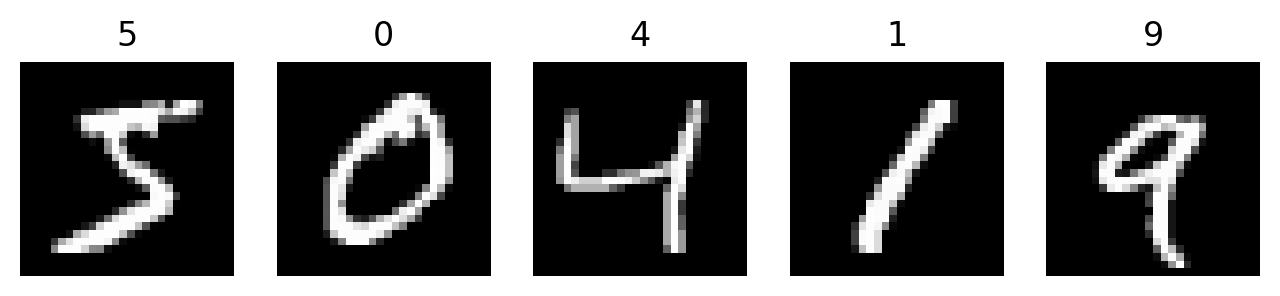

In [4]:
train_dataset,test_dataset=load_minist_dataset()

# flttern the images for sklern mlp
X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

fig, axs = plt.subplots(1, 5, figsize=(8, 10))

#first 5 train samples
for i in range(5):
    axs[i].imshow(X_train[i],cmap='gray')
    axs[i].set_title(y_train[i])
    axs[i].axis('off')


In [5]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,30)
        self.fc2=nn.Linear(30,20)
        self.out=nn.Linear(20,10)
    def forward(self,x):
        x=x.view(x.shape[0],-1)
        x=torch.relu(self.fc1(x))
        x_20=torch.relu(self.fc2(x))
        logits=self.out(x_20)
        return logits,x_20
            

In [6]:
# train the model
Learning_rate=0.0005
model=MLP().to(Device)
optimizer=optim.Adam(model.parameters(),lr=Learning_rate)
criterion=nn.CrossEntropyLoss()
EPOCHS=150

def train_model(model,loader,epochs=EPOCHS):
    model.train() # Sets the model to training mode
    for epoch in range(1,epochs+1):
        running_loss=0.0
        for imgs,labels in loader:
            imgs=imgs.to(Device)
            labels=labels.to(Device)
            optimizer.zero_grad()
            logits,_=model(imgs)
            loss=criterion(logits,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()*imgs.shape[0]
        average_loss=running_loss/len(loader.dataset)
        print(f"Epoch:[{epoch}/{epochs}],loss:{average_loss}")
    print("successfully completed")
    return model

#training the model

if __name__ == "__main__":
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
    
    print("training the model.....")
    model = train_model(model, train_loader, epochs=EPOCHS)


training the model.....
Epoch:[1/150],loss:0.8684181460857391
Epoch:[2/150],loss:0.33660630180040996
Epoch:[3/150],loss:0.27876159450213117
Epoch:[4/150],loss:0.24617897946039835
Epoch:[5/150],loss:0.22231012743314107
Epoch:[6/150],loss:0.20342822882731756
Epoch:[7/150],loss:0.1883751638174057
Epoch:[8/150],loss:0.17545372343858084
Epoch:[9/150],loss:0.1643450054526329
Epoch:[10/150],loss:0.1542528652270635
Epoch:[11/150],loss:0.14607523727814356
Epoch:[12/150],loss:0.1382700177470843
Epoch:[13/150],loss:0.13127616944710413
Epoch:[14/150],loss:0.12503205945094426
Epoch:[15/150],loss:0.11864454804062843
Epoch:[16/150],loss:0.11402642137606939
Epoch:[17/150],loss:0.10903864892323811
Epoch:[18/150],loss:0.10501728823781013
Epoch:[19/150],loss:0.1006801150560379
Epoch:[20/150],loss:0.09707175949811936
Epoch:[21/150],loss:0.09399466910759607
Epoch:[22/150],loss:0.09069899028937022
Epoch:[23/150],loss:0.08756115482648213
Epoch:[24/150],loss:0.0846420256694158
Epoch:[25/150],loss:0.0827591718

In [14]:
# Utility functions

SUBSET_SIZE_PER_CLASS = 1000   # per class -> 10,000 images total

# t-SNE sampling size (embedding points to visualize)
TSNE_SAMPLE = 2000

# Paths
DATA_DIR = "./datasets"

def subsample_indices_by_class(labels, per_class, seed=seed):
    """Return stratified subset indices (balanced per class)."""
    rng = np.random.RandomState(seed)
    labels = np.array(labels)
    indices = []
    for c in np.unique(labels):
        idx_c = np.where(labels == c)[0]
        take = min(per_class, len(idx_c))
        chosen = rng.choice(idx_c, size=take, replace=False)
        indices.extend(chosen.tolist())
    return indices

def evaluate_classifier(y_true, y_pred, labels=list(range(10)), print_report=True):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if print_report:
        print("Accuracy: {:.4f}, Macro F1: {:.4f}".format(acc, f1))
        print("Classification report:\n", classification_report(y_true, y_pred))
    return acc, f1, cm

def plot_confusion_matrix(cm, title="Confusion matrix", labels=list(map(str, range(10))), fname=None):
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    if fname: plt.savefig(fname, bbox_inches='tight', dpi=150)
    plt.show()


MLP Evaluation on MNIST test set:
Accuracy: 0.9619, Macro F1: 0.9615
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.99      0.98      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.95      0.96       982
           5       0.96      0.95      0.95       892
           6       0.96      0.97      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.95      0.95      0.95       974
           9       0.94      0.95      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



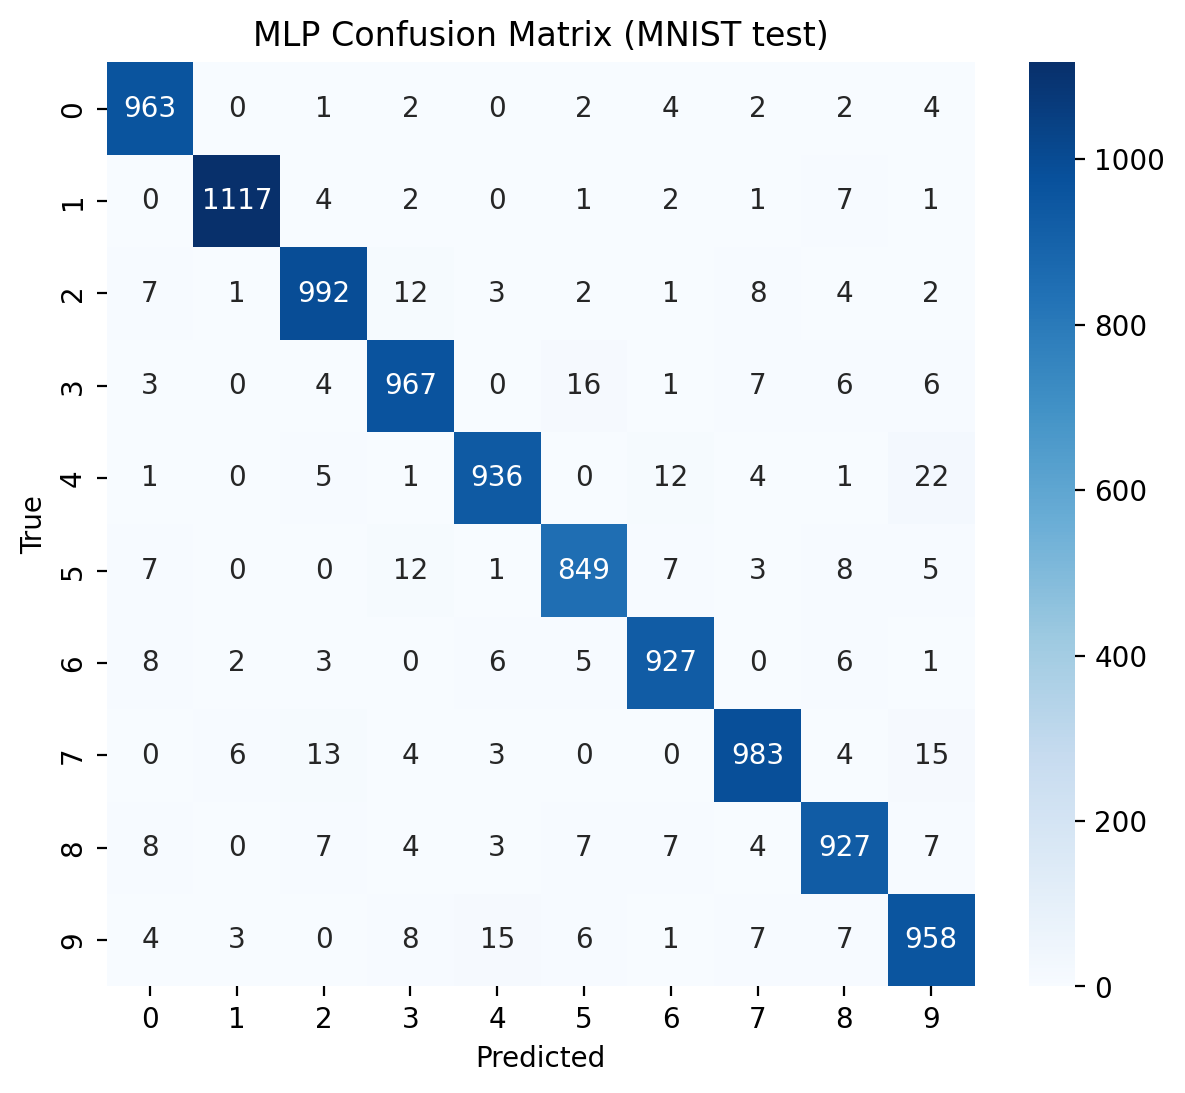

In [15]:

# Evaluate MLP on MNIST test set (and get 20-neuron embeddings)

model.eval()
all_preds = []
all_labels = []
all_embeddings = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(Device)
        logits, emb = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.numpy().tolist())
        all_embeddings.extend(emb.cpu().numpy())

print("\nMLP Evaluation on MNIST test set:")
acc_mlp, f1_mlp, cm_mlp = evaluate_classifier(all_labels, all_preds)
plot_confusion_matrix(cm_mlp, title="MLP Confusion Matrix (MNIST test)", fname="cm_mlp_mnist.png")



**Random Forest and Logistic Regression**

In [16]:
# Convert training data to numpy arrays
X_train = train_dataset.data.numpy().reshape(len(train_dataset), -1)
y_train = train_dataset.targets.numpy()

# Convert test data to numpy arrays
X_test = test_dataset.data.numpy().reshape(len(test_dataset), -1)
y_test = test_dataset.targets.numpy()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)

print(f'Random Forest accuracy: {np.mean(y_rf_pred == y_test)}')

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=0)
lr_model.fit(X_train_scaled, y_train)
y_lr_pred = lr_model.predict(X_test_scaled)

print(f'Logistic Regression accuracy: {np.mean(y_lr_pred == y_test)}')


Random Forest accuracy: 0.9705
Logistic Regression accuracy: 0.9218


Random Forest F1 Score: 0.9702
Logistic Regression F1 Score: 0.9207


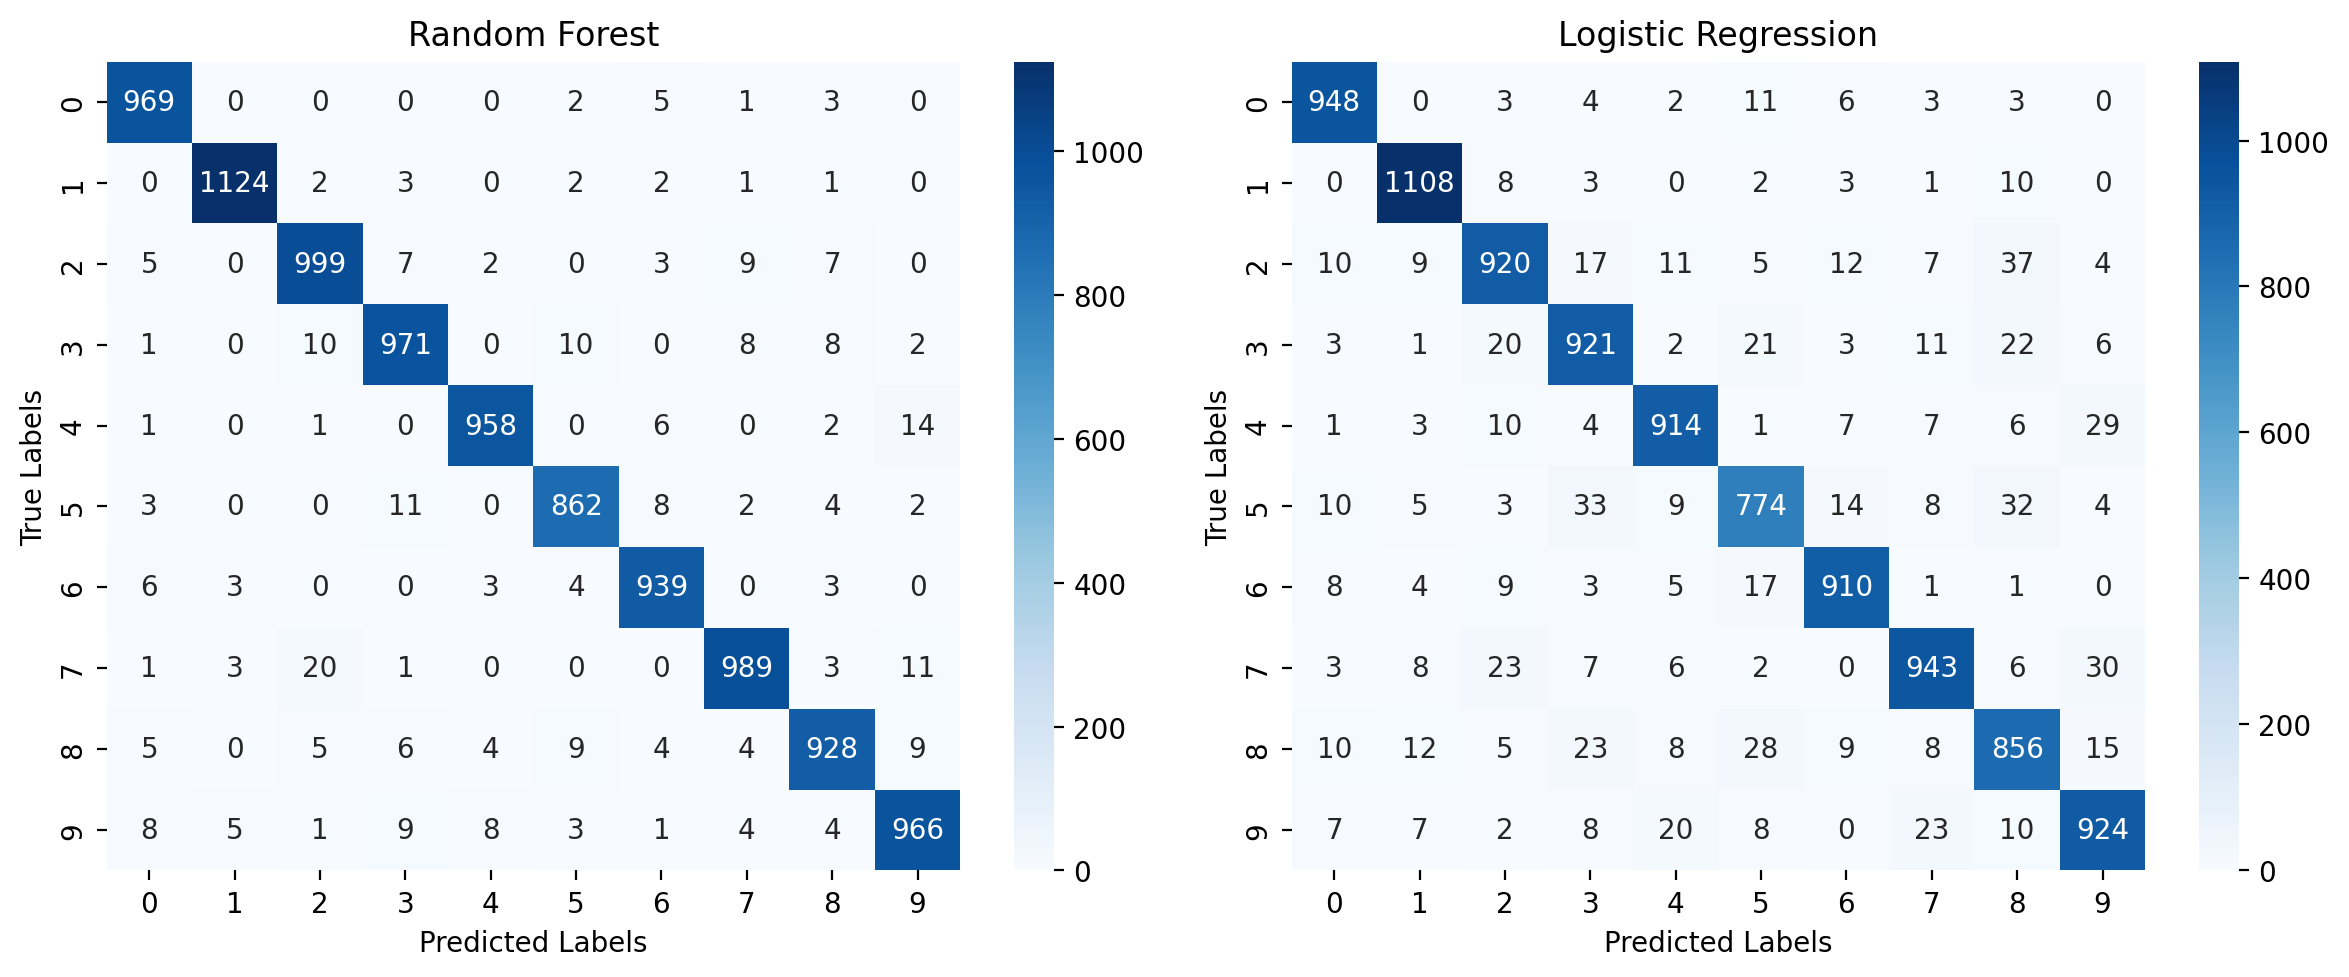

In [17]:
# F1 score and confusion matrix for Random Forest
f1_rf = f1_score(y_test, y_rf_pred, average='macro')

# F1 score and confusion matrix for Logistic Regression
f1_lr = f1_score(y_test, y_lr_pred, average='macro')

# Print F1 scores
print(f'Random Forest F1 Score: {f1_rf:.4f}')
print(f'Logistic Regression F1 Score: {f1_lr:.4f}')

cm_rf = confusion_matrix(y_test, y_rf_pred)
cm_lr = confusion_matrix(y_test, y_lr_pred)

# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Random Forest')
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('Logistic Regression')
axs[1].set_xlabel('Predicted Labels')
axs[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

In [18]:
# classification reports
print('Random Forest Classification Report')
print(classification_report(y_test, y_rf_pred))
print("-"*50)
print('\nLogistic Regression Classification Report')
print(classification_report(y_test, y_lr_pred))

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

--------------------------------------------------

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
  

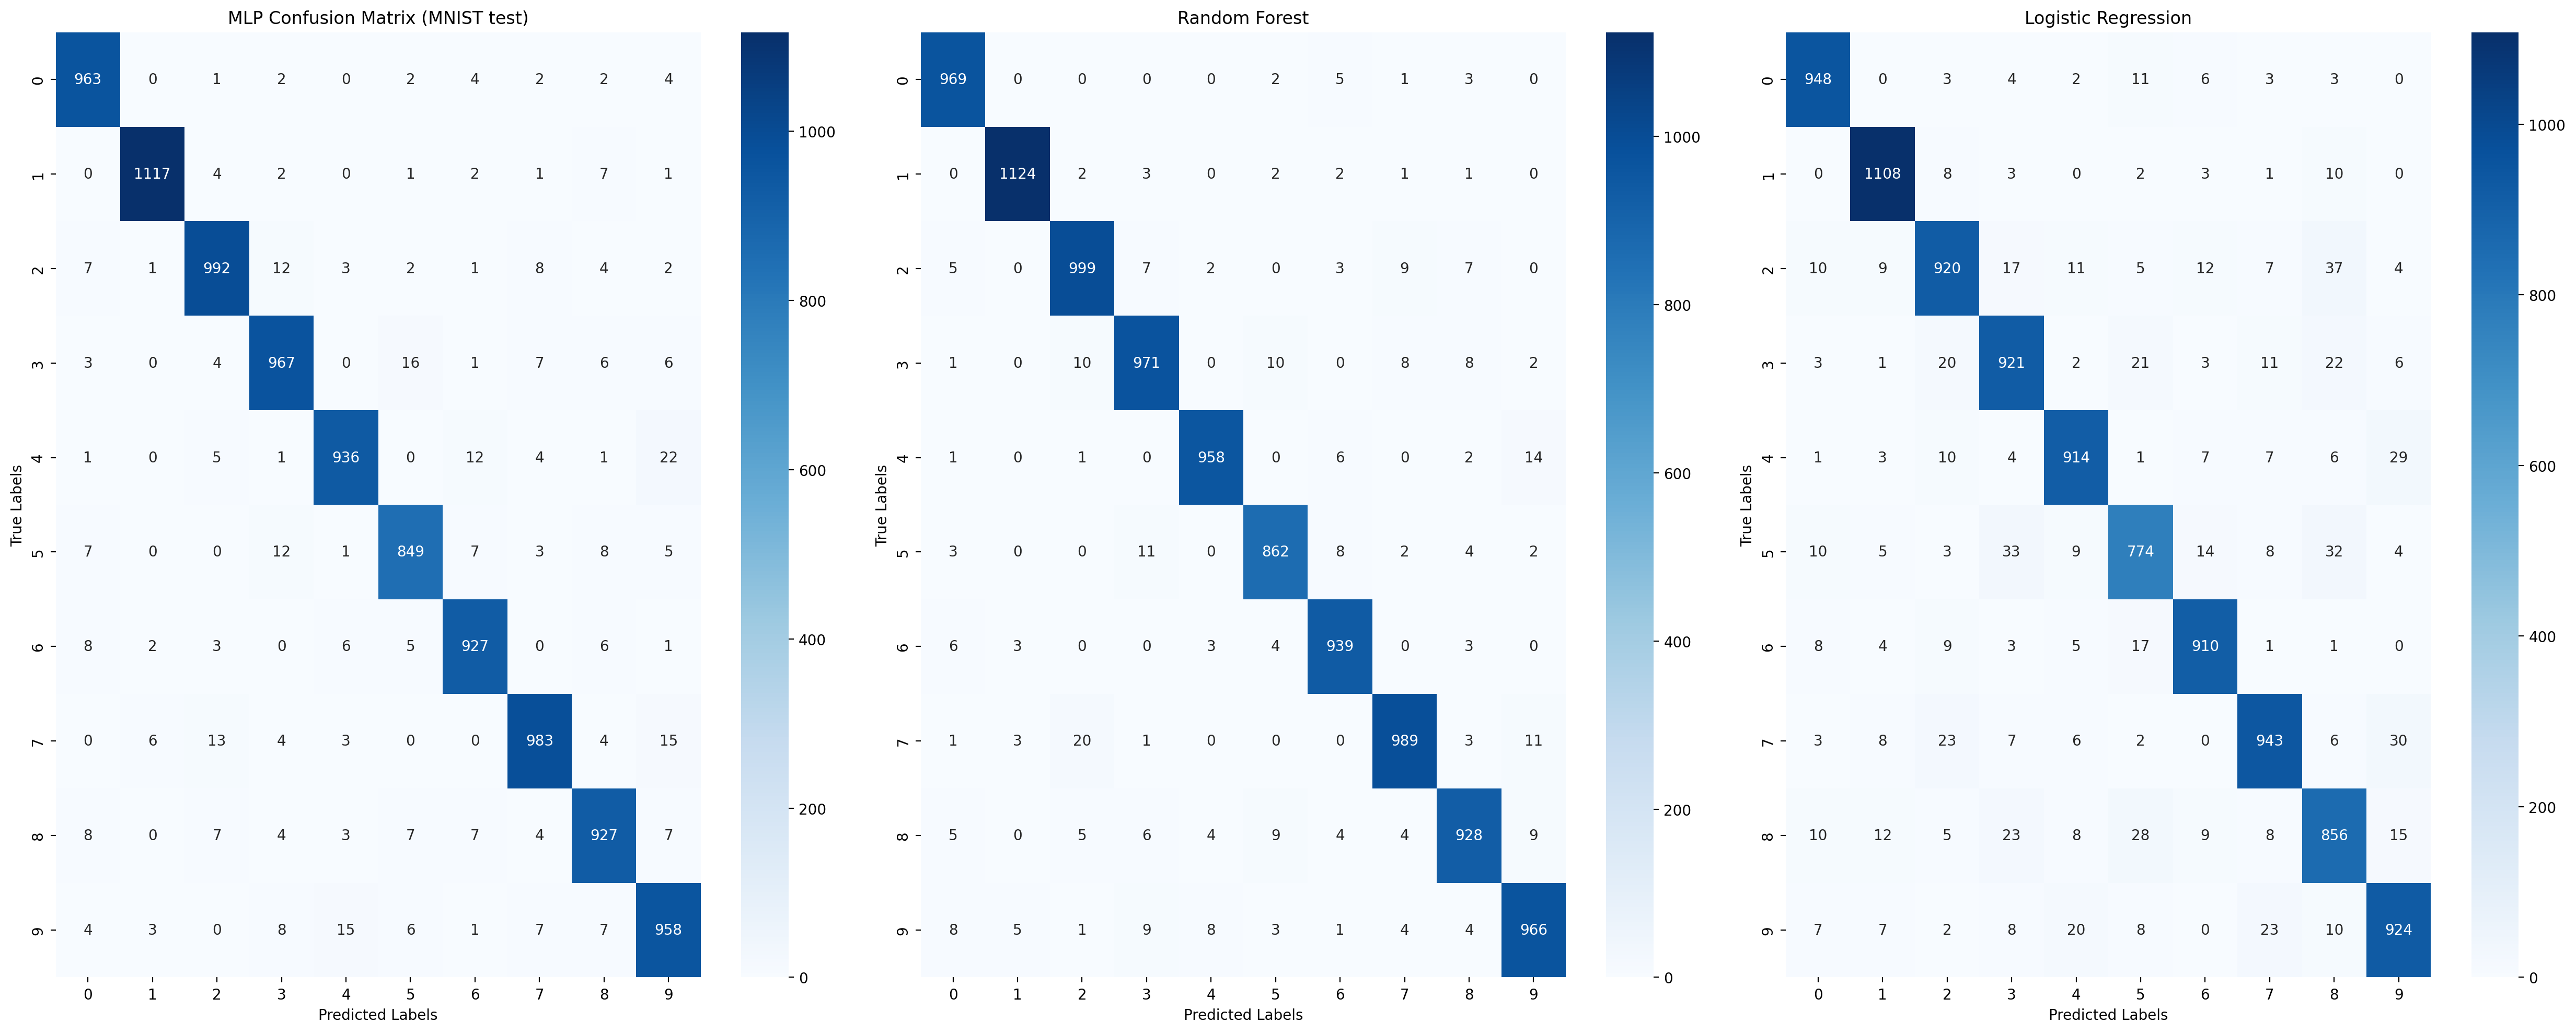

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(25, 10))

# 1. MLP Confusion Matrix
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('MLP Confusion Matrix (MNIST test)')
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')

# 2. Random Forest Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('Random Forest')
axs[1].set_xlabel('Predicted Labels')
axs[1].set_ylabel('True Labels')

# 3. Logistic Regression Confusion Matrix
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axs[2])
axs[2].set_title('Logistic Regression')
axs[2].set_xlabel('Predicted Labels')
axs[2].set_ylabel('True Labels')

plt.tight_layout()
plt.show()


### **Observations**

#### **1. MLP (Multi-Layer Perceptron)**
- **Accuracy:** ~96%  
- **F1 Score:** ~0.96  
- Performs very well with high accuracy and F1 score, slightly below Random Forest.  
- Makes relatively few misclassifications.  
- **Commonly confused digits:** 2 and 7, 3 and 5, 5 and 8, 4 and 9.

---

#### **2. Random Forest**
- **Accuracy:** ~97%  
- **F1 Score:** ~0.97  
- Achieves the best performance among the three models.  
- Slightly fewer misclassifications than MLP.  
- **Commonly confused digits:** 2 and 7, 3 and 5, 4 and 9.

---

#### **3. Logistic Regression**
- **Accuracy:** ~92%  
- **F1 Score:** ~0.92  
- Lowest accuracy and F1 score among the three models.  
- Shows a higher number of misclassifications in the confusion matrix.  
- **Commonly confused digits:** 0 and 5, 2 and 7, 2 and 8, 3 and 5, 3 and 8, 5 and 8, 3 and 2 etc.

---

### **Conclusion**

- **Random Forest** slightly outperforms MLP and provides the highest accuracy and F1 score on the MNIST dataset.  
- **MLP** also performs strongly and is close to Random Forest, becuase of its ability to learn non-linear patterns in the data.  
- **Logistic Regression**, being a linear model, is less effective at capturing complex image patterns and therefore performs the weakest.

Both Random Forest and MLP achieve high performance (~96–97%), which is expected for the MNIST dataset. Logistic Regression reaches around 92%, consistent with its simpler linear nature.

---



**Visualize t-SNE of the 20-neuron layer for the 10 digits for the trained and untrained model and compare the two.**



Running t-SNE for untrained MLP embeddings (MNIST test)...


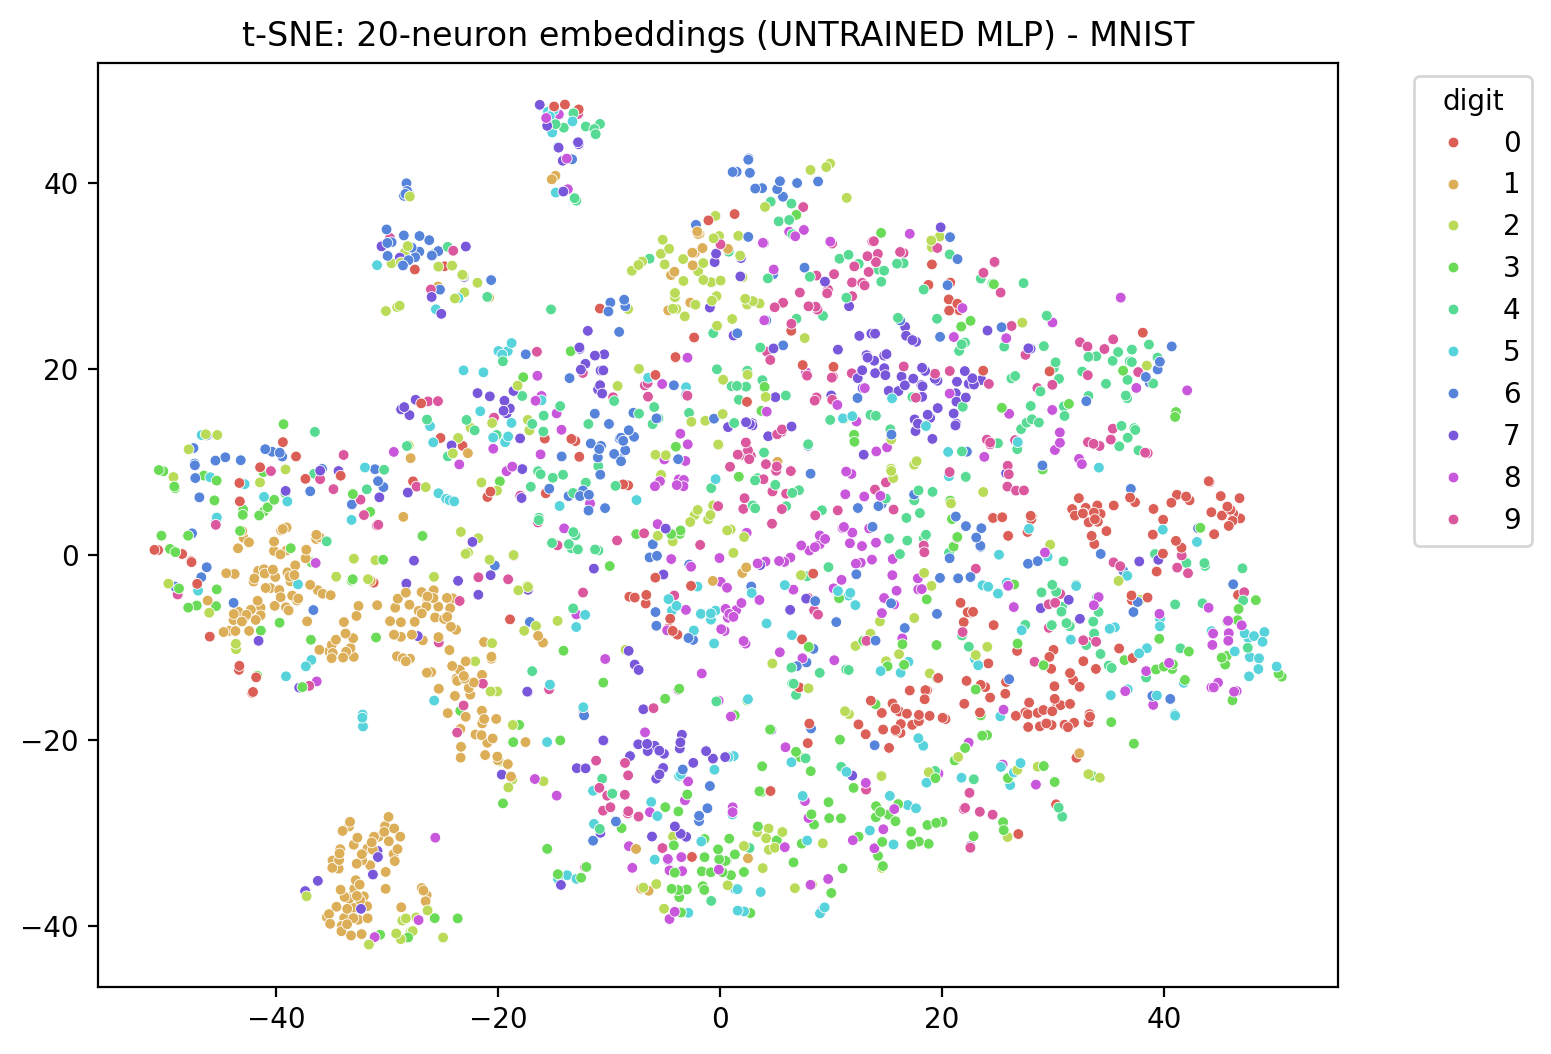


Running t-SNE for trained MLP embeddings (MNIST test)...


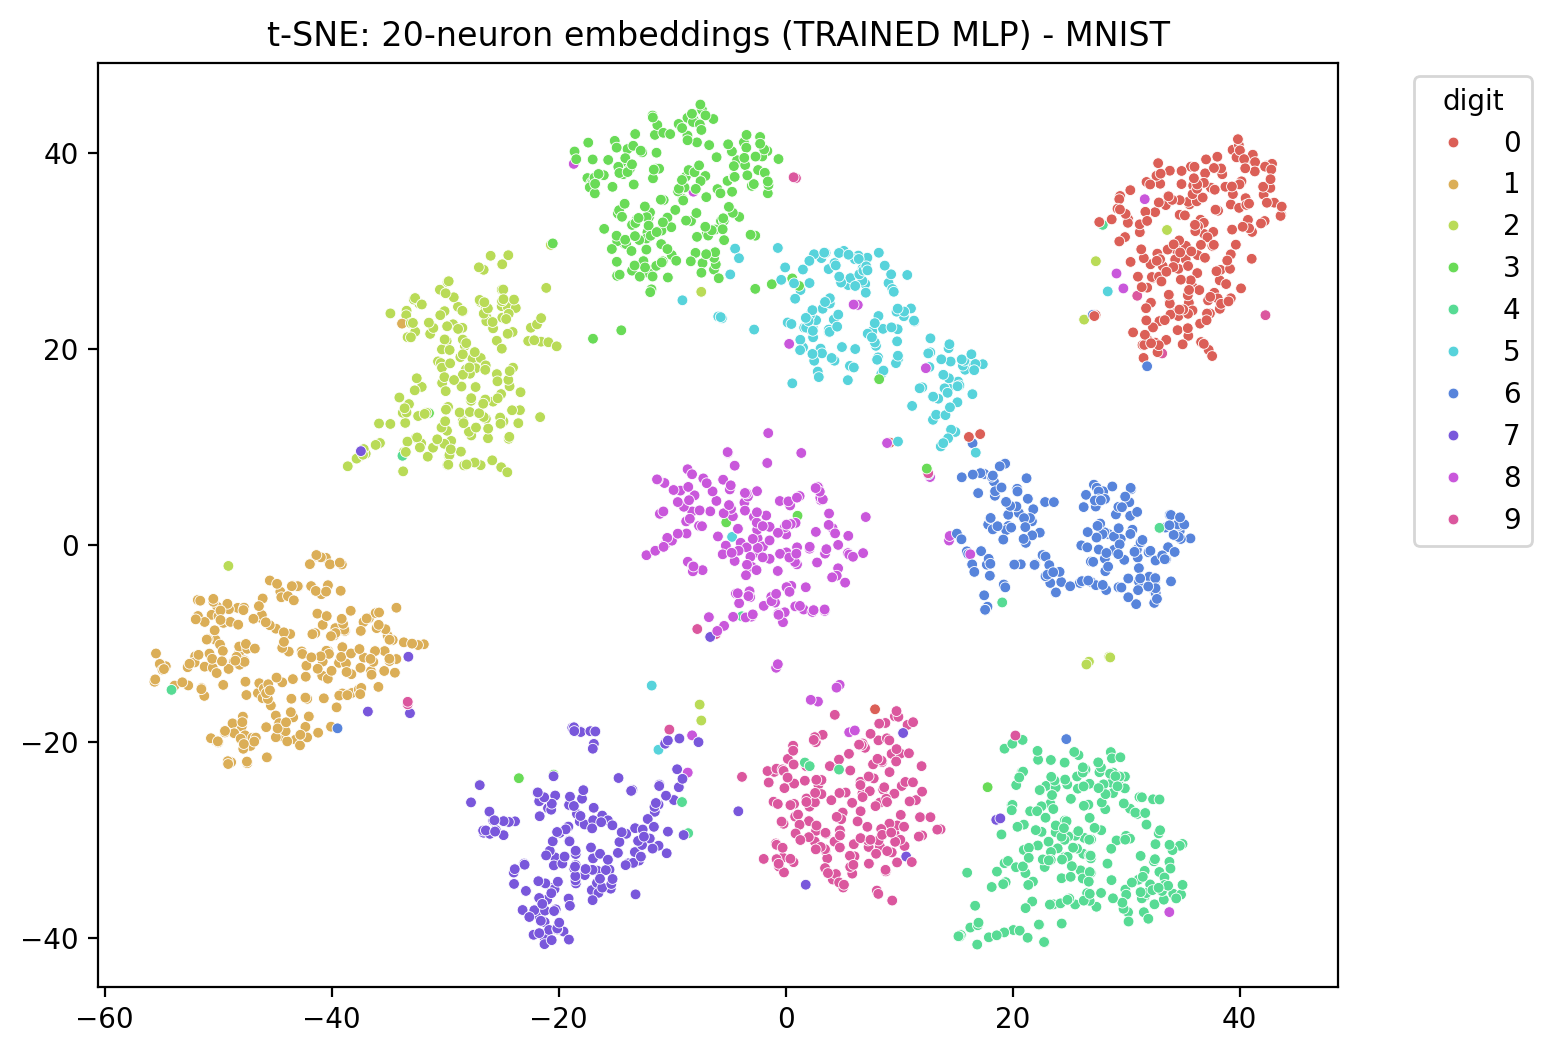

array([[ -1.9276986,  -6.178836 ],
       [-18.790813 , -18.582506 ],
       [-41.34698  ,  -1.1379346],
       ...,
       [-45.427013 , -14.789235 ],
       [  1.2987082, -30.02943  ],
       [-15.628435 ,  39.244934 ]], dtype=float32)

In [22]:
def tsne_and_plot(embeddings, labels, title, sample_size=TSNE_SAMPLE, fname=None):
    """Compute t-SNE on embeddings and plot a 2D scatter colored by labels.
       embeddings: (N, D) numpy array
       labels: length N
    """
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    n = embeddings.shape[0]
    if sample_size is not None and n > sample_size:
        rng = np.random.RandomState(seed)
        idx = rng.choice(n, size=sample_size, replace=False)
        embeddings = embeddings[idx]
        labels = labels[idx]

    # scale embeddings before t-SNE
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)

    tsne = TSNE(n_components=2, random_state=seed, init='pca', learning_rate='auto', perplexity=30)
    X2 = tsne.fit_transform(embeddings_scaled)

    plt.figure(figsize=(8,6))
    palette = sns.color_palette("hls", 10)
    sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=labels, legend='full', palette=palette, s=15)
    plt.title(title)
    plt.legend(title='digit', bbox_to_anchor=(1.05, 1), loc='upper left')
    if fname: plt.savefig(fname, bbox_inches='tight', dpi=150)
    plt.show()
    return X2

# t-SNE of 20-neuron layer: Untrained vs Trained

# Untrained model embeddings
untrained_model = MLP().to(Device)  # fresh random weights
untrained_model.eval()
emb_untrained = []
labels_untrained = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(Device)
        _, emb = untrained_model(imgs)
        emb_untrained.extend(emb.cpu().numpy())
        labels_untrained.extend(labels.numpy())
print("\nRunning t-SNE for untrained MLP embeddings (MNIST test)...")
tsne_and_plot(emb_untrained, labels_untrained, "t-SNE: 20-neuron embeddings (UNTRAINED MLP) - MNIST", fname="tsne_untrained_mnist.png")

# Trained model embeddings
print("\nRunning t-SNE for trained MLP embeddings (MNIST test)...")
tsne_and_plot(all_embeddings, all_labels, "t-SNE: 20-neuron embeddings (TRAINED MLP) - MNIST", fname="tsne_trained_mnist.png")


### **t-SNE Visualization (Untrained vs Trained Model)**

The task is to visualize t-SNE projections of the 20-neuron hidden layer for all 10 digit classes, for both:
- **Untrained model**, and  
- **Trained model**.

**Observations:**
- **Untrained model:** The embeddings are random because the model’s weights are not yet trained. t-SNE shows scattered points with no clear grouping—digits are mixed and no clusters are formed.
- **Trained model:** After training, the embeddings become meaningful. t-SNE forms distinct clusters where each cluster represents a digit (0–9). This shows that the model has learned to separate digit features in its latent space.

**Conclusion:**  
Training transforms random feature representations into well-separated clusters, indicating learned structure and class separation in the hidden layer.

Test the trained MLP on Fashion-MNIST dataset. What do you observe? Compare t-SNE plots for MNIST and Fashion-MNIST embeddings for the layer with 20 neurons.

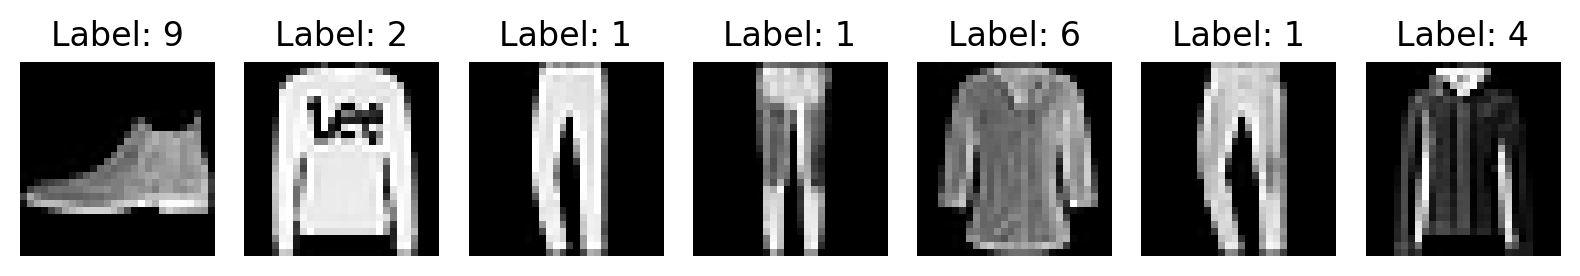


Trained MNIST-MLP evaluated on Fashion-MNIST test set (labels are fashion class indices):
Accuracy: 0.0498, Macro F1: 0.0455
Classification report:
               precision    recall  f1-score   support

           0       0.01      0.01      0.01      1000
           1       0.06      0.00      0.01      1000
           2       0.00      0.00      0.00      1000
           3       0.18      0.17      0.18      1000
           4       0.00      0.00      0.00      1000
           5       0.02      0.05      0.03      1000
           6       0.13      0.22      0.16      1000
           7       0.01      0.01      0.01      1000
           8       0.52      0.03      0.05      1000
           9       0.01      0.01      0.01      1000

    accuracy                           0.05     10000
   macro avg       0.09      0.05      0.05     10000
weighted avg       0.09      0.05      0.05     10000



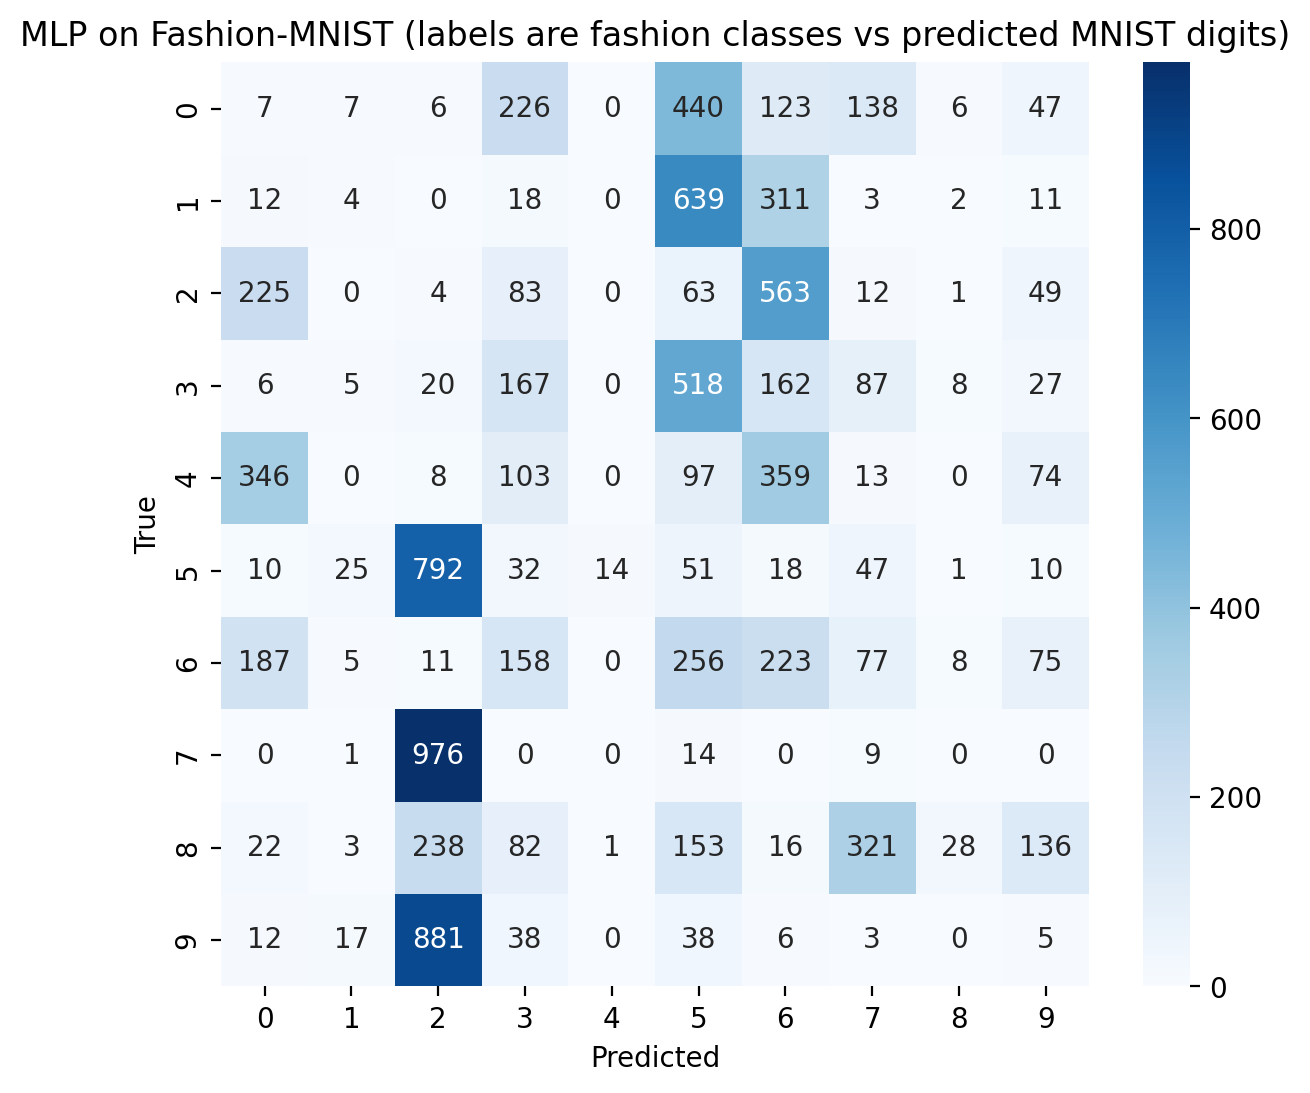

Running t-SNE for Fashion-MNIST embeddings...


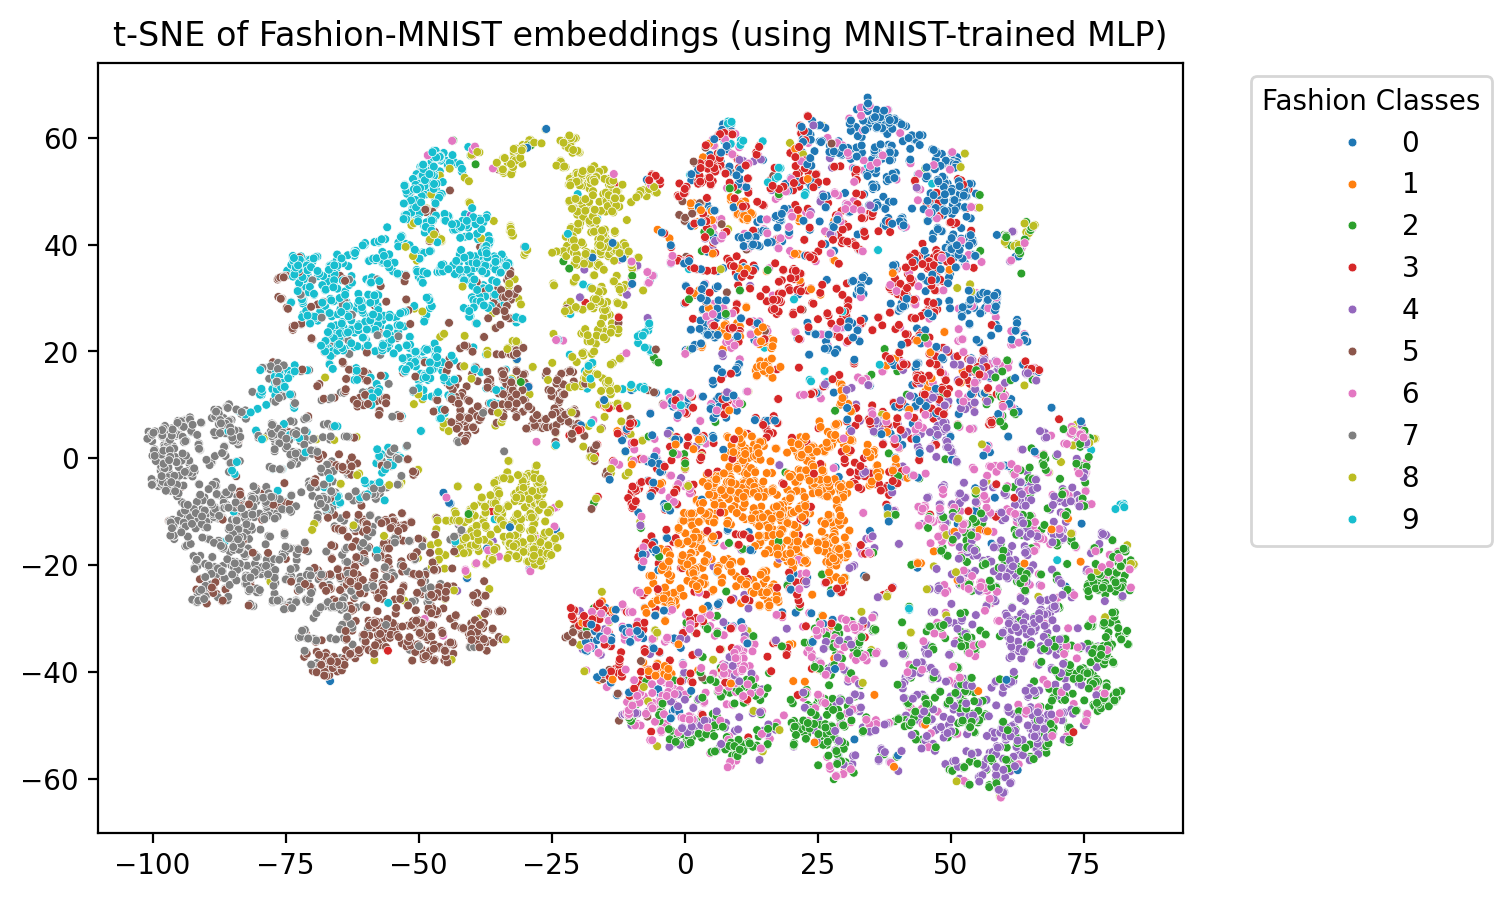

In [23]:
# Test trained MLP on Fashion-MNIST

# define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])
fashion_test = datasets.FashionMNIST(DATA_DIR, download=True, train=False, transform=transform)
fashion_loader = DataLoader(fashion_test, batch_size=128, shuffle=False)
# Plot first few images
fig, axs = plt.subplots(1, 7, figsize=(8, 10))

for i in range(7):
    image, label = fashion_test[i]
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].set_title(f'Label: {label}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

fashion_preds = []
fashion_labels = []
fashion_embs = []

model.eval()
with torch.no_grad():
    for imgs, labels in fashion_loader:
        imgs = imgs.to(Device)
        logits, emb = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        fashion_preds.extend(preds.tolist())
        fashion_labels.extend(labels.numpy().tolist())
        fashion_embs.extend(emb.cpu().numpy())

print("\nTrained MNIST-MLP evaluated on Fashion-MNIST test set (labels are fashion class indices):")
acc_fashion, f1_fashion, cm_fashion = evaluate_classifier(fashion_labels, fashion_preds)
plot_confusion_matrix(cm_fashion, title="MLP on Fashion-MNIST (labels are fashion classes vs predicted MNIST digits)", fname="cm_mlp_fashion.png")


print("Running t-SNE for Fashion-MNIST embeddings...")
fashion_tsne = TSNE(n_components=2, random_state=seed, init='pca', learning_rate='auto').fit_transform(
    StandardScaler().fit_transform(fashion_embs)
)

plt.figure(figsize=(7,5))
sns.scatterplot(x=fashion_tsne[:,0], y=fashion_tsne[:,1], hue=fashion_labels, palette='tab10', s=10)
plt.title("t-SNE of Fashion-MNIST embeddings (using MNIST-trained MLP)")
plt.legend(title='Fashion Classes', bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()



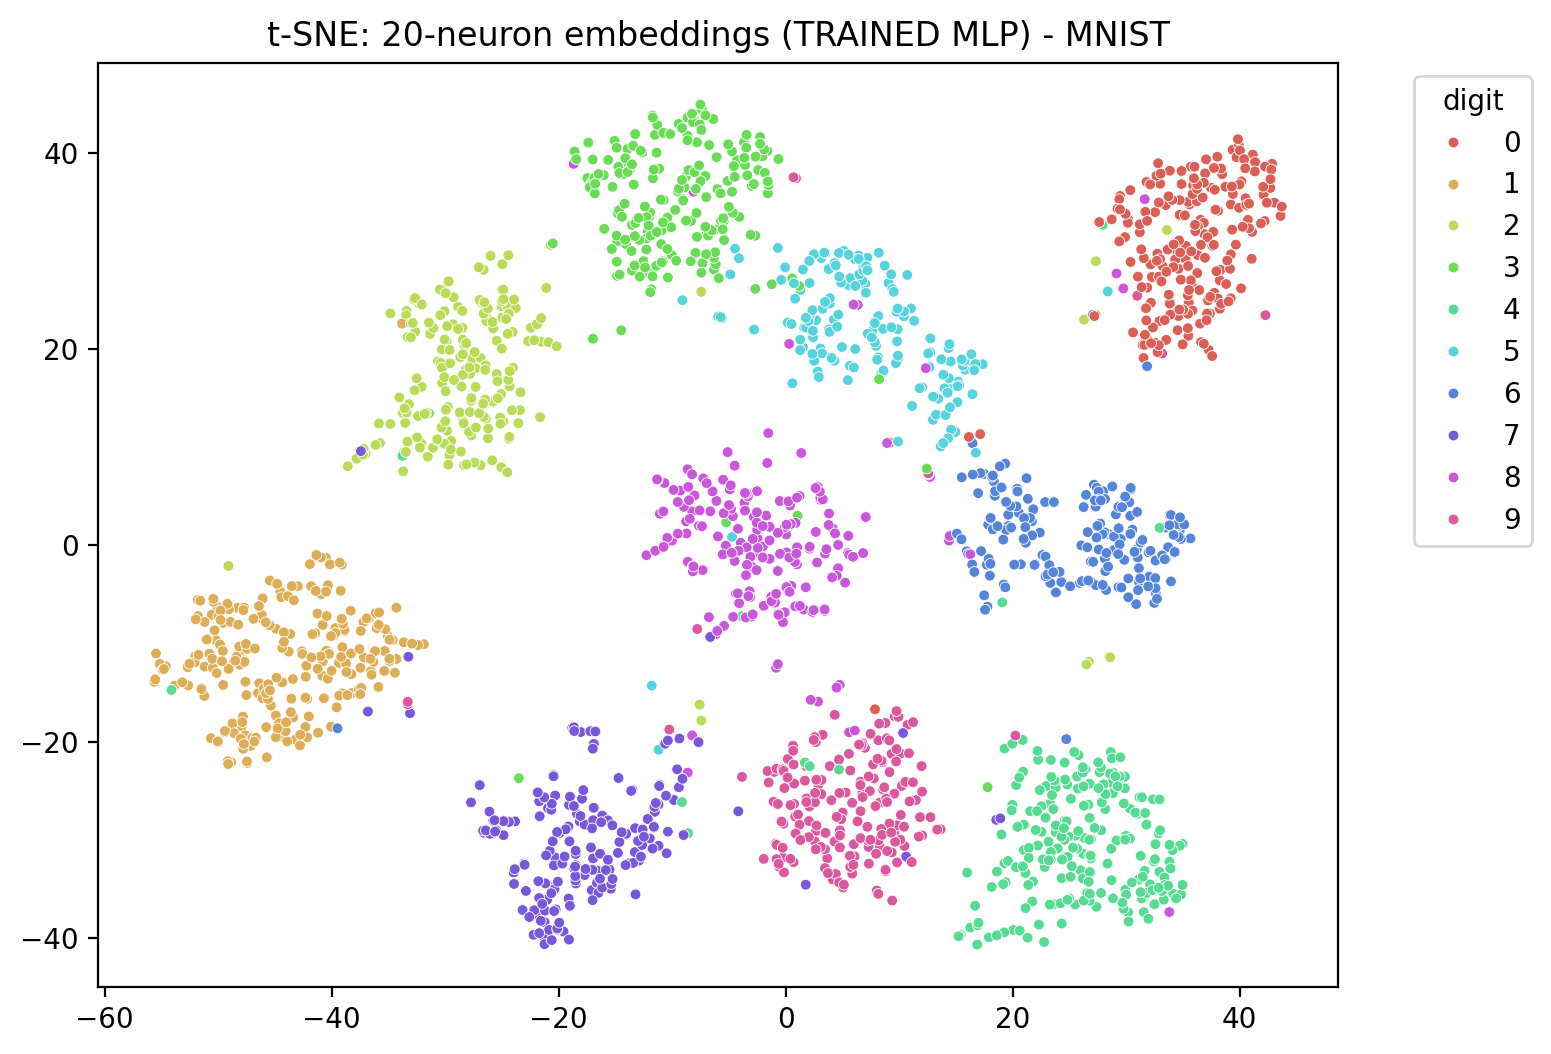

### Observations on Fashion-MNIST using MNIST-trained MLP

- The MLP was trained only on digit images (MNIST), not fashion items.
- When tested on Fashion-MNIST, the accuracy significantly drops, showing poor generalization to new visual categories.
- The confusion matrix shows the model randomly maps fashion classes to digit labels because it has never learned fashion-specific features.
- t-SNE embedding comparison:
  - MNIST embeddings form clear, well-separated clusters (digits 0–9).
  - Fashion-MNIST embeddings are scattered and overlapping, showing that the model cannot produce meaningful representations for fashion images.
